In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from GPy.models import GPRegression
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.acquisition.acquisition_per_cost import acquisition_per_expected_cost
from emukit.core.interfaces.models import IModel
from emukit.experimental_design import ExperimentalDesignLoop
import plotly.graph_objects as go
import itertools
from sklearn.svm import SVR
import copy
from mfed.pde import pde_runner
from mfed.plot import plot
from IPython.display import Video


In [2]:
f_y = lambda x: len(np.where(x > 4.25)[0])

param = {"pde_name":"brusselator","t_range":10,"diff":1,"dt":1e-03,"seed":100,"dim_data":1,"f_y":f_y}

pde_client = pde_runner(param,f_y)
Video("./../assets/brusselator/baseline.mp4")

In [3]:

dt_list = [1e-1,1e-3]
diff_list = np.linspace(0.1,0.9,2)
X = np.array(list(itertools.product(dt_list,diff_list)))
Y = pde_client(X)


100%|██████████| 4/4 [01:29<00:00, 22.33s/it]


In [4]:
# Boiler plate for plotting 
mesh_size = 50
space = ParameterSpace([ContinuousParameter('diff', X[:,0].min(), X[:,0].max()),
                        ContinuousParameter('dt', X[:,1].min(), X[:,1].max())])
x_monte_carlo = np.vstack([np.ones((mesh_size))*space.parameters[0].min,
                np.linspace(X[:,1].min(),X[:,1].max(),mesh_size)]).T

# Scatter plot 
fig = go.Figure(data=[go.Scatter3d(x=X[:,0],y=X[:,1],z=Y.reshape((-1)),mode="markers",marker_symbol="x",marker_size=5)])
fig.show()

In [5]:
# Define and fit a GP model 

kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[0.1,0.1],variance=1)
model_gpy = GPRegression(X,Y,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_gpy.optimize()
print("Param: ",model_gpy.param_array)
#model_gpy.parameters[0].lengthscale.fix()


Param:  [1.         0.12864017 0.1        0.05      ]


In [6]:
class CostModel(IModel):
    def __init__(self,pde_client):
        self.clf = SVR()
        self.pde_client = pde_client
        self.fit()
    
    def fit(self):
        dt = np.array(self.pde_client.cost)[:,0].reshape((-1,1))
        cost = np.array(self.pde_client.cost)[:,1]
        self.clf.fit(dt,cost)

    def predict(self, X: np.ndarray):
        w = self.clf.predict(X[:,0].reshape((-1,1))).reshape((-1,1))
        return (w,X)


cost_model = CostModel(pde_client) # Fit a linear model on the costs 
model_emukit = GPyModelWrapper(model_gpy)
model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)
plot(X,Y,model_variance)




In [7]:

weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
plot(X,Y,weighted_variance)

In [8]:

model_emukit = GPyModelWrapper(model_gpy)

expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                        space = space,
                                        acquisition = weighted_variance,
                                        batch_size = 1)

100%|██████████| 1/1 [00:19<00:00, 19.82s/it]


100%|██████████| 1/1 [00:20<00:00, 20.11s/it]


100%|██████████| 1/1 [00:19<00:00, 19.14s/it]


100%|██████████| 1/1 [00:21<00:00, 21.43s/it]


100%|██████████| 1/1 [00:23<00:00, 23.91s/it]


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


100%|██████████| 1/1 [00:21<00:00, 21.38s/it]


100%|██████████| 1/1 [00:20<00:00, 20.76s/it]


100%|██████████| 1/1 [00:20<00:00, 20.78s/it]


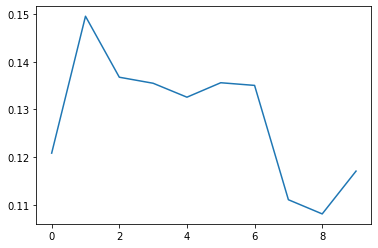

In [9]:
max_iterations = 10
l = []
data_dump = []
for i in range(max_iterations):
    expdesign_loop.run_loop(pde_client, 1)
    cost_model.fit()
    X_new = np.array([i.X for i in expdesign_loop.loop_state.results])
    Y_new = np.array([i.Y for i in expdesign_loop.loop_state.results])
    model_variance = IntegratedVarianceReduction(model=expdesign_loop.model,space=space,x_monte_carlo=x_monte_carlo)
    weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
    plot(np.vstack((X,X_new)),np.vstack((Y,Y_new)),weighted_variance)
    l.append(expdesign_loop.model.model.param_array[1])
    data_dump.append([np.vstack((X,X_new)),np.vstack((Y,Y_new)),copy.deepcopy(weighted_variance),copy.deepcopy(model_variance)])
plt.plot(l)

    

In [ ]:


mesh_size=50
x_1_space = np.linspace(X[:,0].min(),X[:,0].max(),mesh_size)
x_2_space = np.linspace(X[:,1].min(),X[:,1].max(),mesh_size)
xx, yy = np.meshgrid(x_1_space,x_2_space)
X_mesh = np.hstack([xx.reshape((-1,1)),yy.reshape((-1,1))])

data_proc = []
prev_utility = np.log(data_dump[0][2].evaluate(X_mesh).reshape((mesh_size,mesh_size)))
un_prev_utility = np.log(data_dump[0][3].evaluate(X_mesh).reshape((mesh_size,mesh_size)))

for i in data_dump:
    utility = np.log(i[2].evaluate(X_mesh).reshape((mesh_size,mesh_size)))
    un_utility = np.log(i[3].evaluate(X_mesh).reshape((mesh_size,mesh_size)))
    for n in np.linspace(0,1,10):
        convex_utility = n*utility + (1-n)*prev_utility
        un_convex_utility = n*un_utility + (1-n)*un_prev_utility
        data_proc.append([i[0][:,0],i[0][:,1],convex_utility,un_convex_utility])
    prev_utility = utility
    un_prev_utility = un_utility



In [ ]:
min_val = 0
weighted = True
idx_ = 2 if weighted else 3
fig = go.Figure(
    data=[go.Surface(x=xx,y=yy,z=data_proc[0][idx_], opacity=0.7, showscale=False,colorscale ='RdBu'),
    go.Scatter3d(x=data_proc[0][0],y=data_proc[0][1],z=[min_val]*data_proc[0][0].shape[0],mode="markers",marker_symbol="x",marker_size=5)],#data_proc[0][2].min()
    layout=go.Layout(
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, {"frame": {"duration": 300, "redraw": True},"fromcurrent": True, "transition": {"duration": 0}}])])]),
    frames=[go.Frame(
        data=[go.Surface(x=xx,y=yy,z=data_proc[i][idx_], opacity=0.7, showscale=False,colorscale ='RdBu'),
        go.Scatter3d(x=data_proc[i][0],y=data_proc[i][1],z=[min_val]*data_proc[i][0].shape[0],mode="markers",marker_symbol="x",marker_size=5)])#data_proc[i][2].min()
        for i in range(len(data_proc))]
)

#or i in frames:
 #   i.layout.update(scene=dict(zaxis=dict(type='log')))
fig.update_layout(
    scene = dict(
        
        zaxis = dict(nticks=4, range=[min_val,np.max(data_proc[0][2])],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()